# PIV analysis

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 9

In [31]:
#import json
#from scipy import stats
#import scipy.interpolate as interp
#import sys
#sys.path.append('/home/claudio/Documents/Atos/pyModules')

In [38]:
from skimage import io
from skimage import exposure
from skimage.morphology import disk
from skimage.filters.rank import maximum, minimum

## Read images

In [33]:
im_a = io.imread('./images/naca23012_dinamico_24deg_fin1_1_a.bmp', as_grey=True)
im_b = io.imread('./images/naca23012_dinamico_24deg_fin1_1_b.bmp', as_grey=True)

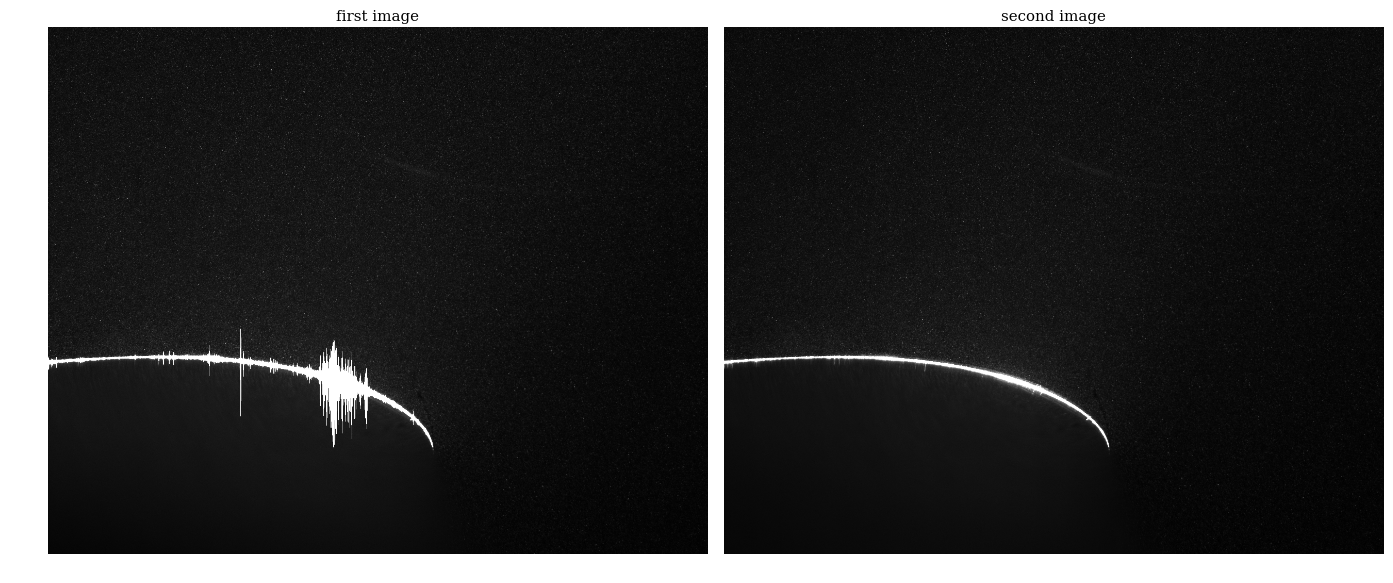

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(im_a, cmap=plt.cm.gray)
ax[0].set_title("first image")

ax[1].imshow(im_b, cmap=plt.cm.gray)
ax[1].set_title("second image")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Size of images

In [35]:
im_a.shape

(1024, 1280)

# Preprocess

## Histogram

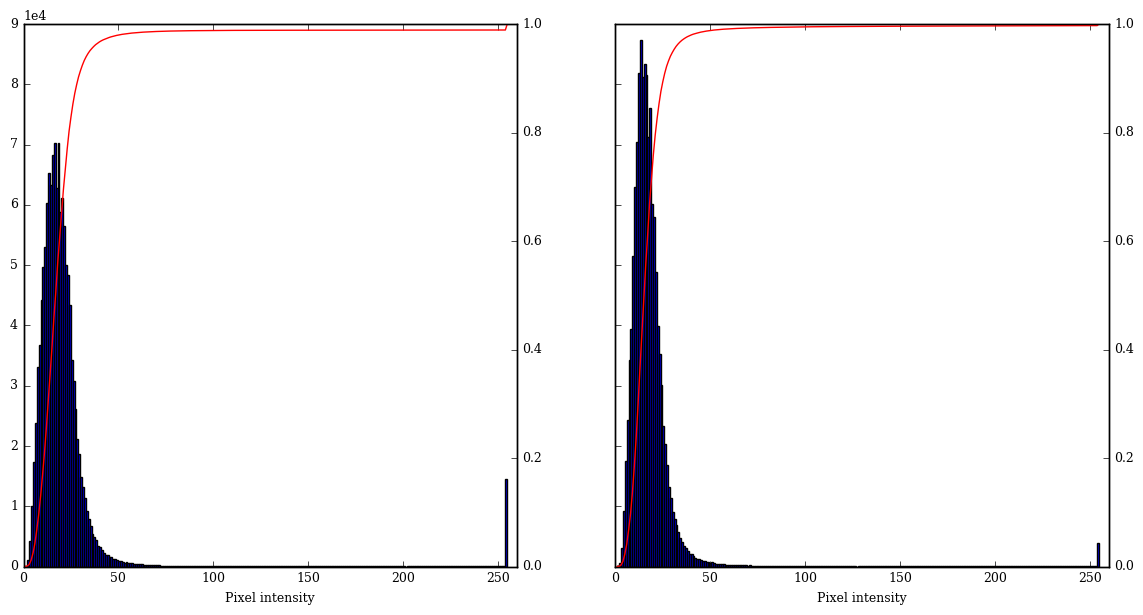

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
bins = 256

img = [im_a, im_b]

for i in range(2):
    ax_cdf = ax[i].twinx()
    ax[i].hist(img[i].ravel(), bins=bins)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_xlabel('Pixel intensity')
    ax[i].set_xlim(0, 260)
    img_cdf, bins1 = exposure.cumulative_distribution(img[i], bins)
    ax_cdf.plot(bins1, img_cdf, 'r')


## Min Max Filter

In [39]:
ul = maximum(im_a, disk(5))
il = minimum(im_a, disk(5))

im_a_filt = (im_a - il)/(ul - il)

/home/claudio/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


In [40]:
im_a_filt.shape

(1024, 1280)

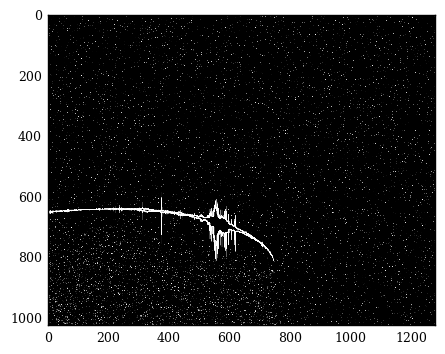

In [42]:
plt.imshow(im_a_filt, cmap=plt.cm.gray )